In [21]:
### Importing Modules
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn import metrics

In [22]:
#Importing Datasets
Transaction_Info=pd.read_csv("data-new/transactions_obf.csv")
Reported_Frauds=pd.read_csv("data-new/labels_obf.csv")
Transaction_Info['merchantCountry']

0         826
1         826
2         442
3         826
4         826
         ... 
118616    826
118617    826
118618    826
118619    826
118620    826
Name: merchantCountry, Length: 118621, dtype: int64

In [23]:
#Splitting Date/Time Feature
Transaction_Info["transactionDate"]=pd.to_datetime(Transaction_Info["transactionTime"]).dt.date
Transaction_Info["transactionTime"]=pd.to_datetime(Transaction_Info["transactionTime"]).dt.time
DateSplit=pd.DataFrame([str(i).split('-') for i in Transaction_Info.transactionDate],columns=['transactionYear','transactionMonth','transactionDay'])
TimeSplit=pd.DataFrame([str(i).split(':')[0:3] for i in Transaction_Info.transactionTime],columns=['transactionHour','transactionMinute','transactionSecond'])
Transaction_Info[['transactionHour','transactionMinute','transactionSecond']]=TimeSplit.astype(int)
Transaction_Info[['transactionYear','transactionMonth','transactionDay']]=DateSplit.astype(int)
Transaction_Info

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,transactionDate,transactionHour,transactionMinute,transactionSecond,transactionYear,transactionMonth,transactionDay
0,00:00:00,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,2017-01-01,0,0,0,2017,1,1
1,00:49:03,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,2017-01-01,0,49,3,2017,1,1
2,00:43:17,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,2017-01-01,0,43,17,2017,1,1
3,00:15:07,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,2017-01-01,0,15,7,2017,1,1
4,00:37:09,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,2017-01-01,0,37,9,2017,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,23:52:16,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,2018-01-30,23,52,16,2018,1,30
118617,23:57:16,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,2018-01-30,23,57,16,2018,1,30
118618,23:59:03,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,2018-01-30,23,59,3,2018,1,30
118619,00:04:44,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,2018-01-31,0,4,44,2018,1,31


In [24]:
#Defining Fraud Labels
Transaction_Info['fraudLabel']=False
for i in Reported_Frauds.eventId:
    Transaction_Info.loc[Transaction_Info.eventId==i,'fraudLabel']=True

In [25]:
#Cleaning Data off of missing and noisy values
Transaction_Info=Transaction_Info[Transaction_Info.posEntryMode!=79]
Transaction_Info=Transaction_Info[Transaction_Info.transactionAmount>0]
Transaction_Info.iloc[Transaction_Info.merchantZip.isnull(),6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="..",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="...",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="....",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip==".....",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="**",6]='0'
Transaction_Info.iloc[Transaction_Info.merchantZip=="***",6]='0'

In [26]:
#Reseting Index after cleaning
Transaction_Info=Transaction_Info.reset_index()
del Transaction_Info['index']

In [27]:
#All Categorical Features
Transaction_Info['merchantZip'].unique()
Transaction_Info['posEntryMode'].unique()
Transaction_Info['mcc'].unique()
Transaction_Info['merchantCountry'].unique()
Transaction_Info['merchantZip'].unique()

array(['CR0', 'DE14', '0', ..., 'E16HU', 'M45JU', 'W84PT'], dtype=object)

In [28]:
# for i in range(len(Transaction_Info)):
#     temporary=Transaction_Info.iloc[0:i+1,[2,11]]
#     anothertemporary=temporary[temporary.accountNumber==list(temporary.accountNumber)[-1]]
#     Transaction_Info.iloc[i,13]=len(anothertemporary[anothertemporary.fraudLabel==1])
#     del temporary,anothertemporary

#     print((i/118621)*100,"%/ rewritten")
# for i in range(len(Transaction_Info)):
#     temporary=Transaction_Info.iloc[0:i+1,[3,11]]
#     anothertemporary=temporary[temporary.merchantId==list(temporary.merchantId)[-1]]
#     Transaction_Info.iloc[i,12]=len(anothertemporary[anothertemporary.fraudLabel==1])
#     del temporary,anothertemporary
#     print((i/118621)*100,"%/ rewritten")


In [29]:
#Converting Categorical Data to Numeric Data
AccountNumberCategories=pd.Categorical(Transaction_Info.accountNumber)
MerchantIdCategories=pd.Categorical(Transaction_Info.accountNumber)
MerchantZip=pd.Categorical(Transaction_Info.merchantZip)
Transaction_Info['accountNumberCodes']=AccountNumberCategories.codes
Transaction_Info['merchantIdCodes']=MerchantIdCategories.codes
Transaction_Info['MerchantZipCodes']=MerchantZip.codes

In [41]:
Transaction_Info['fraudLabel']

0         False
1         False
2         False
3         False
4         False
          ...  
116674    False
116675    False
116676    False
116677    False
116678    False
Name: fraudLabel, Length: 116679, dtype: bool

In [31]:
# Splitting Dataset into False and True Test/Train Sets
TrueTrainCases=Transaction_Info[Transaction_Info.fraudLabel==True].sample(800)
TrueTestCases=pd.concat([Transaction_Info[Transaction_Info.fraudLabel==True],TrueTrainCases]).drop_duplicates(keep=False)#Transaction_Info-TrueTrainCases
FalseTrainCases=Transaction_Info[Transaction_Info.fraudLabel==False].sample(1800)
FalseTestCases=pd.concat([Transaction_Info[Transaction_Info.fraudLabel==False],FalseTrainCases]).drop_duplicates(keep=False)#Transaction_Info-FalseTrainCases

In [32]:
#Features that contribute to the analysis
TrainingIndex=['mcc','posEntryMode','transactionAmount','availableCash','accountNumberCodes','merchantIdCodes','MerchantZipCodes','transactionHour','transactionMinute','transactionSecond','transactionYear','transactionMonth','transactionDay']
TheTrainData=pd.concat([TrueTrainCases,FalseTrainCases])[TrainingIndex+['fraudLabel']]

In [33]:
#Defining the AI Model and  Gridsearch Parameters list 
n_estimators=[i for i in range(5,20,4)]
criterion=["gini", "entropy"]
max_depth=[i for i in range(5,25,4)]
min_samples_split=[i for i in range(5,30,4)]
min_samples_leaf=[i for i in range(3,10)]
max_features=['auto', 'sqrt']
bootstrap=[False]
Parameters= {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion':criterion
    }
#n_jobs=,random_state=,verbose=,warm_start=,class_weight=,max_samples=}
model=RandomForestClassifier()
random_model=GridSearchCV(estimator=model,param_grid=Parameters,verbose=4)


In [37]:
TheTrainData.fraudLabel

75846      True
88928      True
34558      True
115303     True
78366      True
          ...  
113734    False
81145     False
1986      False
73751     False
63617     False
Name: fraudLabel, Length: 2600, dtype: bool

In [34]:
#Fitting the model onto the Train Data  
random_model.fit(TheTrainData[TrainingIndex],TheTrainData['fraudLabel'])
print(random_model.best_params_)

Fitting 5 folds for each of 3920 candidates, totalling 19600 fits
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.825 total time=   0.0s
[CV 2/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.842 total time=   0.0s
[CV 3/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.833 total time=   0.0s
[CV 4/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.823 total time=   0.0s
[CV 5/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5;, score=0.831 total time=   0.0s
[CV 1/5] END bootstrap=False, criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=3, m

In [35]:
#Preparing Test Data
TheTestData=pd.concat([TrueTestCases[TrainingIndex],FalseTestCases.sample(50)])[TrainingIndex+['fraudLabel']]

In [36]:
TheTestData.fraudLabel

14         NaN
15718      NaN
16715      NaN
22072      NaN
29309      NaN
         ...  
33802    False
81254    False
26047    False
44839    False
5603     False
Name: fraudLabel, Length: 100, dtype: object

In [16]:
#Test Predictions
Predictions=pd.Series(random_model.predict(TheTrainData[TrainingIndex]))
Results=TheTrainData.fraudLabel;    Results=Results.reset_index().fraudLabel
print(Predictions)

0        True
1        True
2        True
3        True
4       False
        ...  
2595    False
2596    False
2597    False
2598    False
2599    False
Length: 2600, dtype: bool


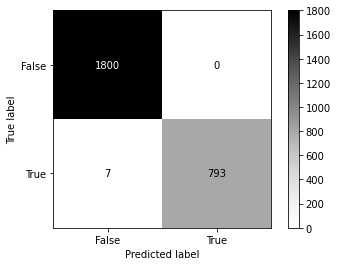

In [17]:
#Performance of the Classifier
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(Results),list(Predictions)),display_labels=["False","True"]).plot(cmap='Greys')

In [19]:
# random_model.score(TheTestData,TheTestData.fraudLabel)
TheTestData

,mcc,posEntryMode,transactionAmount,availableCash,accountNumberCodes,merchantIdCodes,MerchantZipCodes,transactionHour,transactionMinute,transactionSecond,transactionYear,transactionMonth,transactionDay,fraudLabel
2583,4816,81,0.01,2500,552,552,0,6,6,14,2017,1,10,NaN
8028,5999,1,6.33,11500,176,176,0,4,45,41,2017,1,28,NaN
14854,5735,81,8.59,1500,170,170,0,6,0,28,2017,2,21,NaN
15718,5812,81,35.02,500,455,455,0,18,25,17,2017,2,23,NaN
19018,5735,81,10.01,1500,328,328,0,5,44,26,2017,3,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,5651,5,8.00,7500,607,607,204,8,39,50,2017,1,10,False
34363,5947,5,4.00,4500,122,122,275,19,31,2,2017,4,26,False
107988,8043,81,30.00,8500,499,499,316,20,16,56,2017,12,30,False
94116,5251,5,8.49,8500,314,314,1477,19,28,54,2017,11,12,False
